In [1]:
# Install / import packages (run once)
!pip install -q pandas matplotlib seaborn scikit-learn plotly

!pip install -q python-dateutil

import os
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import matplotlib.dates as mdates
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, roc_auc_score
import joblib
import warnings
warnings.filterwarnings("ignore")
plt.rcParams["figure.figsize"] = (12,5)


In [6]:
from pathlib import Path
import shutil
import os

# ✅ Correct folder setup
DATA_DIR = Path("/content/data")
OUT_DIR = Path("/content/outputs")

# ✅ Create folders if not exist
DATA_DIR.mkdir(parents=True, exist_ok=True)
OUT_DIR.mkdir(parents=True, exist_ok=True)

FG_PATH = DATA_DIR / "/content/fear_greed_index.csv"
TRADE_PATH = DATA_DIR / "/content/historical_data.csv"

print("✅ Folders ready:")
print(DATA_DIR, OUT_DIR)


✅ Folders ready:
/content/data /content/outputs


In [8]:
import pandas as pd

df_sentiment = pd.read_csv(FG_PATH)
df_trades = pd.read_csv(TRADE_PATH)

df_sentiment.head(), df_trades.head()


(    timestamp  value classification        date
 0  1517463000     30           Fear  2018-02-01
 1  1517549400     15   Extreme Fear  2018-02-02
 2  1517635800     40           Fear  2018-02-03
 3  1517722200     24   Extreme Fear  2018-02-04
 4  1517808600     11   Extreme Fear  2018-02-05,
                                       Account  Coin  Execution Price  \
 0  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9769   
 1  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9800   
 2  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9855   
 3  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9874   
 4  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9894   
 
    Size Tokens  Size USD Side     Timestamp IST  Start Position Direction  \
 0       986.87   7872.16  BUY  02-12-2024 22:50        0.000000       Buy   
 1        16.00    127.68  BUY  02-12-2024 22:50      986.524596       Buy   
 2       144.09   1150.63  BUY 

In [9]:
#  List files present
for p in DATA_DIR.glob("*"):
    print(p.name)


fear_greed_index.csv
historical_data.csv


In [10]:
# Basic safe loader
def try_read_csv(path):
    for enc in ["utf-8", "latin1", "utf-16"]:
        try:
            return pd.read_csv(path, encoding=enc)
        except Exception as e:
            last_e = e
    raise last_e

hist = try_read_csv("/content/historical_data.csv")
fg = try_read_csv("/content/fear_greed_index.csv")

print("Historical shape:", hist.shape)
print("Sentiment shape:", fg.shape)

Historical shape: (211224, 16)
Sentiment shape: (2644, 4)


In [11]:
# Quick preview
display(hist.head(5))
display(hist.columns)
display(fg.head(5))
display(fg.columns)


,Account,Coin,Execution Price,Size Tokens,Size USD,Side,Timestamp IST,Start Position,Direction,Closed PnL,Transaction Hash,Order ID,Crossed,Fee,Trade ID,Timestamp
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,02-12-2024 22:50,0.000000,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.345404,8.950000e+14,1.730000e+12
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,02-12-2024 22:50,986.524596,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.005600,4.430000e+14,1.730000e+12
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,02-12-2024 22:50,1002.518996,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050431,6.600000e+14,1.730000e+12
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,BUY,02-12-2024 22:50,1146.558564,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050043,1.080000e+15,1.730000e+12
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,BUY,02-12-2024 22:50,1289.488521,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.003055,1.050000e+15,1.730000e+12


Index(['Account', 'Coin', 'Execution Price', 'Size Tokens', 'Size USD', 'Side',
       'Timestamp IST', 'Start Position', 'Direction', 'Closed PnL',
       'Transaction Hash', 'Order ID', 'Crossed', 'Fee', 'Trade ID',
       'Timestamp'],
      dtype='object')

,timestamp,value,classification,date
0,1517463000,30,Fear,2018-02-01
1,1517549400,15,Extreme Fear,2018-02-02
2,1517635800,40,Fear,2018-02-03
3,1517722200,24,Extreme Fear,2018-02-04
4,1517808600,11,Extreme Fear,2018-02-05


Index(['timestamp', 'value', 'classification', 'date'], dtype='object')

In [12]:
# Standardize column names (strip whitespace) and preview
hist.columns = [c.strip() for c in hist.columns]
fg.columns = [c.strip() for c in fg.columns]
hist.head(3)


,Account,Coin,Execution Price,Size Tokens,Size USD,Side,Timestamp IST,Start Position,Direction,Closed PnL,Transaction Hash,Order ID,Crossed,Fee,Trade ID,Timestamp
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,02-12-2024 22:50,0.000000,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.345404,8.950000e+14,1.730000e+12
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,02-12-2024 22:50,986.524596,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.005600,4.430000e+14,1.730000e+12
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,02-12-2024 22:50,1002.518996,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050431,6.600000e+14,1.730000e+12


In [13]:
# Parse timestamps (robust)
# The historical data may use "Timestamp IST" or "Timestamp"; we try both.
from dateutil import parser

def parse_hist_timestamp(df):
    df = df.copy()
    # Try common candidates
    ts_candidates = [c for c in df.columns if "timestamp" in c.lower() or "time" in c.lower()]
    if len(ts_candidates) == 0:
        # assume last column is timestamp
        ts_col = df.columns[-1]
    else:
        ts_col = ts_candidates[0]

    df['raw_timestamp_col'] = df[ts_col].astype(str)
    # Try multiple formats with dateutil parser; handle day-first format typical of dd-mm-yyyy
    def try_parse(x):
        x = str(x).strip()
        if x.lower() in ["nan", "none", ""]:
            return pd.NaT
        # some timestamps may be like "02-12-2024 22:50" (dd-mm-yyyy)
        for fmt in ("%d-%m-%Y %H:%M", "%Y-%m-%d %H:%M:%S", "%Y-%m-%d %H:%M", "%d/%m/%Y %H:%M", "%d-%m-%Y"):
            try:
                return pd.to_datetime(x, format=fmt, dayfirst=True)
            except:
                pass
        # try as unix timestamp (if numeric)
        try:
            v = float(x)
            # if large (>=1e9) treat as unix seconds
            if v > 1e9:
                return pd.to_datetime(v, unit='s')
        except:
            pass
        # fallback to dateutil parser
        try:
            return parser.parse(x, dayfirst=True)
        except:
            return pd.NaT

    df['Timestamp_parsed'] = df['raw_timestamp_col'].apply(try_parse)
    return df

hist = parse_hist_timestamp(hist)
print("Parsed timestamps — nulls:", hist['Timestamp_parsed'].isna().sum())
display(hist[['raw_timestamp_col','Timestamp_parsed']].head(6))


Parsed timestamps — nulls: 0


,raw_timestamp_col,Timestamp_parsed
0,02-12-2024 22:50,2024-12-02 22:50:00
1,02-12-2024 22:50,2024-12-02 22:50:00
2,02-12-2024 22:50,2024-12-02 22:50:00
3,02-12-2024 22:50,2024-12-02 22:50:00
4,02-12-2024 22:50,2024-12-02 22:50:00
5,02-12-2024 22:50,2024-12-02 22:50:00


In [14]:
# Parse sentiment timestamps and values
def parse_sentiment(df):
    df = df.copy()
    # If there is a unix 'timestamp' column (int), convert to datetime
    if 'timestamp' in df.columns:
        # integer unix seconds -> datetime
        df['date_parsed'] = pd.to_datetime(df['timestamp'], unit='s', errors='coerce')
    elif 'date' in df.columns:
        df['date_parsed'] = pd.to_datetime(df['date'], errors='coerce', dayfirst=True)
    else:
        # try first column
        df['date_parsed'] = pd.to_datetime(df.iloc[:,0], errors='coerce', dayfirst=True)
    # numeric value
    if 'value' in df.columns:
        df['value'] = pd.to_numeric(df['value'], errors='coerce')
    # classification as category
    if 'classification' in df.columns:
        df['classification'] = df['classification'].astype(str)
    return df

fg = parse_sentiment(fg)
display(fg.head(5))
print("Sentiment dates null:", fg['date_parsed'].isna().sum())


,timestamp,value,classification,date,date_parsed
0,1517463000,30,Fear,2018-02-01,2018-02-01 05:30:00
1,1517549400,15,Extreme Fear,2018-02-02,2018-02-02 05:30:00
2,1517635800,40,Fear,2018-02-03,2018-02-03 05:30:00
3,1517722200,24,Extreme Fear,2018-02-04,2018-02-04 05:30:00
4,1517808600,11,Extreme Fear,2018-02-05,2018-02-05 05:30:00


Sentiment dates null: 0


In [15]:
# Clean numeric columns in historical data
num_cols = ['Execution Price','Size Tokens','Size USD','Closed PnL','Fee']
for c in num_cols:
    if c in hist.columns:
        hist[c] = pd.to_numeric(hist[c], errors='coerce')

# Clean Side/Direction/Account columns
for c in ['Side','Direction','Account','Coin']:
    if c in hist.columns:
        hist[c] = hist[c].astype(str)

# Drop fully empty columns
hist = hist.loc[:, ~hist.columns.duplicated()]
hist = hist.dropna(how='all', axis=1)

display(hist[num_cols + ['Account','Side']].head(5))


,Execution Price,Size Tokens,Size USD,Closed PnL,Fee,Account,Side
0,7.9769,986.87,7872.16,0.0,0.345404,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,BUY
1,7.9800,16.00,127.68,0.0,0.005600,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,BUY
2,7.9855,144.09,1150.63,0.0,0.050431,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,BUY
3,7.9874,142.98,1142.04,0.0,0.050043,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,BUY
4,7.9894,8.73,69.75,0.0,0.003055,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,BUY


In [16]:
# Add day/date columns and other useful fields
hist['date'] = hist['Timestamp_parsed'].dt.date
hist['year'] = hist['Timestamp_parsed'].dt.year
hist['hour'] = hist['Timestamp_parsed'].dt.hour
# profitable trade boolean
if 'Closed PnL' in hist.columns:
    hist['profit_flag'] = hist['Closed PnL'] > 0
else:
    hist['profit_flag'] = np.nan

# ensure Size USD exists
if 'Size USD' not in hist.columns:
    hist['Size USD'] = pd.to_numeric(hist.get('Size USD', 0), errors='coerce')

hist.head(3)


,Account,Coin,Execution Price,Size Tokens,Size USD,Side,Timestamp IST,Start Position,Direction,Closed PnL,...,Crossed,Fee,Trade ID,Timestamp,raw_timestamp_col,Timestamp_parsed,date,year,hour,profit_flag
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,02-12-2024 22:50,0.000000,Buy,0.0,...,True,0.345404,8.950000e+14,1.730000e+12,02-12-2024 22:50,2024-12-02 22:50:00,2024-12-02,2024,22,False
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,02-12-2024 22:50,986.524596,Buy,0.0,...,True,0.005600,4.430000e+14,1.730000e+12,02-12-2024 22:50,2024-12-02 22:50:00,2024-12-02,2024,22,False
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,02-12-2024 22:50,1002.518996,Buy,0.0,...,True,0.050431,6.600000e+14,1.730000e+12,02-12-2024 22:50,2024-12-02 22:50:00,2024-12-02,2024,22,False


In [17]:
# Simple dedup and basic filtering
# Drop duplicate exact rows
hist = hist.drop_duplicates()
# Remove rows with no timestamp
hist = hist[~hist['Timestamp_parsed'].isna()].copy()
print("After dropping duplicates & missing timestamps:", hist.shape)


After dropping duplicates & missing timestamps: (211224, 22)


In [18]:
# Aggregate trades by account & date (daily metrics)
def aggregate_daily(df):
    ag = df.groupby(['Account','date']).agg(
        trades_count = ('Account','size'),
        total_size_usd = ('Size USD','sum'),
        avg_execution_price = ('Execution Price','mean'),
        sum_pnl = ('Closed PnL','sum'),
        mean_pnl = ('Closed PnL','mean'),
        win_rate = ('profit_flag', lambda x: np.nan if len(x)==0 else np.mean(x.astype(float))),
        avg_leverage = ('Crossed', lambda x: np.nan)  # placeholder if no leverage column; will replace below
    ).reset_index()
    return ag

daily = aggregate_daily(hist)
# If there's a leverage column or 'leverage' present, compute mean leverage instead (replace avg_leverage)
for lev_col in ['leverage','Leverage','Start Position']:  # try possible names
    if lev_col in hist.columns:
        try:
            daily = daily.drop(columns=['avg_leverage'], errors='ignore')
            daily = daily.merge(
                hist.groupby(['Account','date'])[lev_col].mean().rename('avg_leverage').reset_index(),
                on=['Account','date'], how='left'
            )
            break
        except:
            pass

display(daily.head(8))


,Account,date,trades_count,total_size_usd,avg_execution_price,sum_pnl,mean_pnl,win_rate,avg_leverage
0,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-11,177,900880.13,3204.461017,0.000000,0.000000,0.000000,-153.887539
1,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-17,68,542413.18,653.365147,0.000000,0.000000,0.000000,-495.998138
2,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-18,40,949380.00,3164.600000,0.000000,0.000000,0.000000,-456.894920
3,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-22,12,338240.00,3382.400000,-21227.000000,-1768.916667,0.000000,-634.747083
4,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-26,27,465700.00,232.921111,1603.100000,59.374074,0.444444,-512.998889
5,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-28,82,1316799.98,2691.556585,-132271.000000,-1613.060976,0.000000,-450.264821
6,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-30,23,1116918.77,3723.017391,0.000000,0.000000,0.000000,-441.570065
7,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-12-06,33,1212299.96,4041.000000,-175611.000056,-5321.545456,0.000000,-509.005303


In [19]:
# Merge sentiment to daily aggregates
# Create date field in sentiment (date only)
fg['date'] = fg['date_parsed'].dt.date

# Merge on date
merged = pd.merge(daily, fg[['date','value','classification']].drop_duplicates(), on='date', how='left')
print("Merged shape:", merged.shape)
display(merged.head(8))


Merged shape: (2341, 11)


,Account,date,trades_count,total_size_usd,avg_execution_price,sum_pnl,mean_pnl,win_rate,avg_leverage,value,classification
0,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-11,177,900880.13,3204.461017,0.000000,0.000000,0.000000,-153.887539,76.0,Extreme Greed
1,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-17,68,542413.18,653.365147,0.000000,0.000000,0.000000,-495.998138,90.0,Extreme Greed
2,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-18,40,949380.00,3164.600000,0.000000,0.000000,0.000000,-456.894920,83.0,Extreme Greed
3,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-22,12,338240.00,3382.400000,-21227.000000,-1768.916667,0.000000,-634.747083,94.0,Extreme Greed
4,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-26,27,465700.00,232.921111,1603.100000,59.374074,0.444444,-512.998889,79.0,Extreme Greed
5,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-28,82,1316799.98,2691.556585,-132271.000000,-1613.060976,0.000000,-450.264821,77.0,Extreme Greed
6,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-30,23,1116918.77,3723.017391,0.000000,0.000000,0.000000,-441.570065,84.0,Extreme Greed
7,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-12-06,33,1212299.96,4041.000000,-175611.000056,-5321.545456,0.000000,-509.005303,72.0,Greed


In [20]:
#  If sentiment is daily but you have intraday trades,
# This preserves intraday mapping. We'll create a trade-level DataFrame with attached sentiment.

# Prepare sentiment as time series sorted by date_parsed
fg_time = fg[['date_parsed','value']].dropna().sort_values('date_parsed').drop_duplicates(subset=['date_parsed'])
# Prepare trades with Timestamp_parsed
trades_time = hist[['Account','Timestamp_parsed','Execution Price','Size USD','Closed PnL','profit_flag']].copy().dropna(subset=['Timestamp_parsed'])
trades_time = trades_time.sort_values('Timestamp_parsed')

# merge_asof requires both sorted and same dtype
trades_time = pd.merge_asof(trades_time.sort_values('Timestamp_parsed'),
                            fg_time.rename(columns={'date_parsed':'Timestamp_parsed'}),
                            on='Timestamp_parsed', direction='nearest')
# rename sentiment column
if 'value' in trades_time.columns:
    trades_time = trades_time.rename(columns={'value':'sentiment_value'})

display(trades_time.head(6))


,Account,Timestamp_parsed,Execution Price,Size USD,Closed PnL,profit_flag,sentiment_value
0,0x3998f134d6aaa2b6a5f723806d00fd2bbbbce891,2023-05-01 01:06:00,1897.9,156.39,0.0,False,63
1,0x3998f134d6aaa2b6a5f723806d00fd2bbbbce891,2023-05-01 01:06:00,1898.6,137.08,0.0,False,63
2,0x3998f134d6aaa2b6a5f723806d00fd2bbbbce891,2023-05-01 01:06:00,1897.9,183.53,0.0,False,63
3,0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23,2023-12-05 03:11:00,41866.0,24370.62,0.0,False,75
4,0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23,2023-12-05 03:11:00,41867.0,628.00,0.0,False,75
5,0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23,2023-12-05 03:11:00,2231.0,8685.73,0.0,False,75


In [21]:
# Basic EDA & correlations
# Correlation between daily sum_pnl and sentiment value (drop na)
corr_df = merged[['sum_pnl','value']].dropna()
print("Pearson correlation (sum_pnl vs sentiment):", corr_df.corr().iloc[0,1])

# Rolling correlation (30-day) across days (aggregate across accounts per day)
ts = merged.groupby('date').agg(sum_pnl=('sum_pnl','sum'), sentiment=('value','mean')).reset_index().sort_values('date')
ts['sum_pnl'] = ts['sum_pnl'].fillna(0)
ts['rolling_corr_30d'] = ts['sum_pnl'].rolling(30, min_periods=5).corr(ts['sentiment'])
display(ts.tail(8))

# Save ts to outputs
ts.to_csv(OUT_DIR / "time_series_agg.csv", index=False)


Pearson correlation (sum_pnl vs sentiment): 0.00017909735384186165


,date,sum_pnl,sentiment,rolling_corr_30d
472,2025-04-24,50704.395965,63.0,-0.286210
473,2025-04-25,20218.859206,60.0,-0.276481
474,2025-04-26,-4125.753942,65.0,-0.282494
475,2025-04-27,2702.067468,61.0,-0.284499
476,2025-04-28,36906.813759,54.0,-0.290573
477,2025-04-29,125749.613427,60.0,-0.248775
478,2025-04-30,14003.797269,56.0,-0.258374
479,2025-05-01,54536.829297,53.0,-0.261102


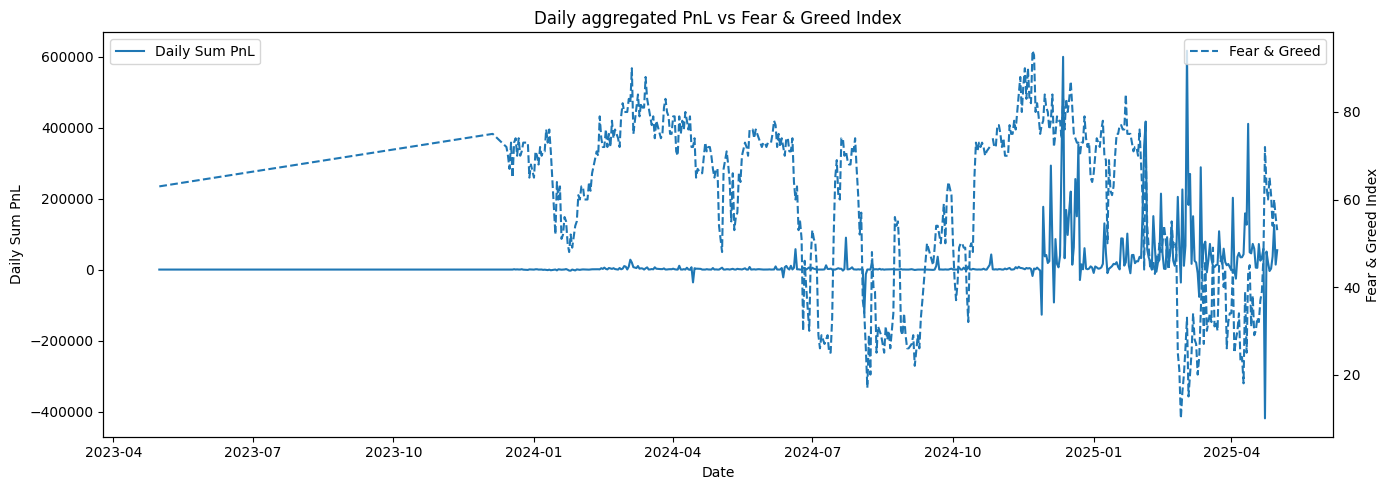

In [22]:
# Visualizations: Time series PnL vs Sentiment
fig, ax1 = plt.subplots(figsize=(14,5))
ax1.plot(ts['date'], ts['sum_pnl'], label='Daily Sum PnL')
ax1.set_ylabel('Daily Sum PnL')
ax1.set_xlabel('Date')
ax1.legend(loc='upper left')

ax2 = ax1.twinx()
ax2.plot(ts['date'], ts['sentiment'], label='Fear & Greed', linestyle='--')
ax2.set_ylabel('Fear & Greed Index')
ax2.legend(loc='upper right')

plt.title('Daily aggregated PnL vs Fear & Greed Index')
plt.tight_layout()
plt.savefig(OUT_DIR / "pnl_vs_sentiment_time_series.png", dpi=150)
plt.show()


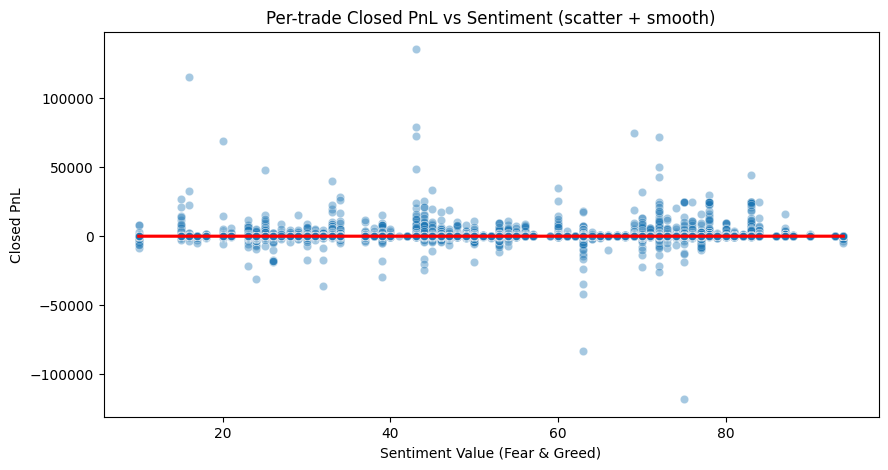

In [23]:
# Visual: Distribution of per-trade PnL vs sentiment_value (scatter + smooth)
plt.figure(figsize=(10,5))
sns.scatterplot(data=trades_time, x='sentiment_value', y='Closed PnL', alpha=0.4)
sns.regplot(data=trades_time.dropna(subset=['sentiment_value','Closed PnL']), x='sentiment_value', y='Closed PnL', scatter=False, lowess=True, line_kws={'color':'red'})
plt.xlabel('Sentiment Value (Fear & Greed)')
plt.ylabel('Closed PnL')
plt.title('Per-trade Closed PnL vs Sentiment (scatter + smooth)')
plt.savefig(OUT_DIR / "trade_pnl_vs_sentiment_scatter.png", dpi=150)
plt.show()


In [24]:
# Create sentiment buckets and compute stats by bucket
# We'll create quintiles or use classification (Fear/Greed) if available
if 'classification' in fg.columns and fg['classification'].notna().any():
    # map classification to trades_time via nearest
    trades_time = trades_time.merge(fg[['date_parsed','classification']].drop_duplicates().rename(columns={'date_parsed':'Timestamp_parsed'}),
                                    on='Timestamp_parsed', how='left')
    trades_time['sent_bucket'] = trades_time['classification']
else:
    # numeric quantile buckets
    trades_time['sent_bucket'] = pd.qcut(trades_time['sentiment_value'].fillna(trades_time['sentiment_value'].median()), 5, labels=False)

bucket_stats = trades_time.groupby('sent_bucket').agg(
    mean_pnl = ('Closed PnL','mean'),
    median_pnl = ('Closed PnL','median'),
    win_rate = ('profit_flag', lambda x: np.mean(x.dropna().astype(float)) if len(x.dropna())>0 else np.nan),
    trades = ('Closed PnL','count')
).reset_index()
display(bucket_stats)
bucket_stats.to_csv(OUT_DIR / "bucket_stats.csv", index=False)


,sent_bucket,mean_pnl,median_pnl,win_rate,trades
0,Extreme Fear,0.003625,0.000000,0.062500,32
1,Extreme Greed,7.602400,0.497025,0.518182,110
2,Fear,4.549260,0.000000,0.105263,57
3,Greed,14.424345,4.660564,0.676856,229
4,Neutral,0.000000,0.000000,0.000000,14


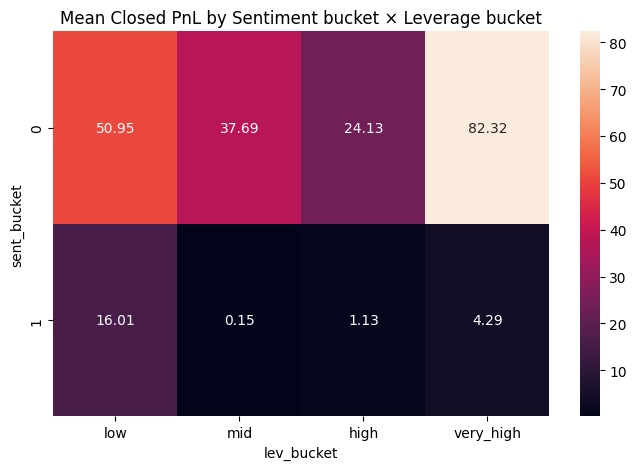

In [28]:
# Heatmap: mean PnL by sentiment bucket × leverage bucket (if leverage info exists)
# Try to find a leverage or 'Start Position' or 'leverage' like column
lev_col = None
for candidate in ['leverage','Leverage','Start Position','StartPosition','Start_Position']:
    if candidate in hist.columns:
        lev_col = candidate
        break

if lev_col is not None:
    hist['lev'] = pd.to_numeric(hist[lev_col], errors='coerce')
    # discretize leverage into buckets
    hist['lev_bucket'] = pd.qcut(hist['lev'].fillna(0)+1e-6, q=4, labels=['low','mid','high','very_high'], duplicates='drop')
    merged_heat = hist.merge(fg[['date_parsed','value']].rename(columns={'date_parsed':'Timestamp_parsed'}), on='Timestamp_parsed', how='left')
    merged_heat['sent_bucket'] = pd.qcut(merged_heat['value'].fillna(merged_heat['value'].median()), 4, labels=False, duplicates='drop')
    # if groupby name has space: handle with .groupby using dictionary access
    # But to be safe:
    heat = merged_heat.groupby(['sent_bucket','lev_bucket'])['Closed PnL'].mean().unstack()
    plt.figure(figsize=(8,5))
    sns.heatmap(heat, annot=True, fmt=".2f")
    plt.title('Mean Closed PnL by Sentiment bucket × Leverage bucket')
    plt.savefig(OUT_DIR / "heatmap_sentiment_leverage.png", dpi=150)
    plt.show()
else:
    print("No leverage-like column found. Skipping leverage heatmap.")

In [29]:
# Modeling: Predict whether a day (account-day) is profitable (classification)
# Use merged (daily) table: create target profitable_day (sum_pnl > 0)
mdl_df = merged.copy()
mdl_df['profitable_day'] = (mdl_df['sum_pnl'] > 0).astype(int)
# features: sentiment value + lagged sentiments
mdl_df = mdl_df.sort_values(['Account','date'])
# Add lagged sentiment per account
mdl_df['sentiment'] = mdl_df['value']
mdl_df['sent_sent_lag1'] = mdl_df.groupby('Account')['sentiment'].shift(1)
mdl_df['sent_sent_lag3'] = mdl_df.groupby('Account')['sentiment'].shift(3)
mdl_df['total_size_usd'] = mdl_df['total_size_usd'].fillna(0)
# Drop rows with missing sentiment
model_df = mdl_df.dropna(subset=['sentiment']).copy()
features = ['sentiment','sent_sent_lag1','sent_sent_lag3','total_size_usd']
model_df = model_df.fillna(0)
X = model_df[features]
y = model_df['profitable_day']

# Train test split by random
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y if y.nunique()>1 else None)

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
probs = clf.predict_proba(X_test)[:,1] if hasattr(clf,'predict_proba') else None

print("Accuracy:", accuracy_score(y_test, pred))
if probs is not None and y_test.nunique()>1:
    print("ROC AUC:", roc_auc_score(y_test, probs))

# feature importances
feat_imp = pd.Series(clf.feature_importances_, index=features).sort_values(ascending=False)
display(feat_imp)
joblib.dump(clf, OUT_DIR / "rf_profitable_day.joblib")


Accuracy: 0.5982905982905983
ROC AUC: 0.6006143344709898


,0
total_size_usd,0.423331
sent_sent_lag3,0.193901
sentiment,0.193268
sent_sent_lag1,0.189500


['/content/outputs/rf_profitable_day.joblib']

In [30]:
# Regression: Predict daily sum_pnl using sentiment and other features
reg_df = merged.copy().dropna(subset=['value'])
reg_df['sum_pnl'] = reg_df['sum_pnl'].fillna(0)
reg_df['lag_sent_1'] = reg_df.groupby('Account')['value'].shift(1).fillna(reg_df['value'].median())
reg_df['lag_sent_3'] = reg_df.groupby('Account')['value'].shift(3).fillna(reg_df['value'].median())
reg_features = ['value','lag_sent_1','lag_sent_3','total_size_usd']
reg_df = reg_df.fillna(0)
Xr = reg_df[reg_features]
yr = reg_df['sum_pnl']

Xr_train, Xr_test, yr_train, yr_test = train_test_split(Xr, yr, test_size=0.2, random_state=1)

rfr = RandomForestRegressor(n_estimators=150, random_state=1)
rfr.fit(Xr_train, yr_train)
pred_r = rfr.predict(Xr_test)
print("Regression MSE:", mean_squared_error(yr_test, pred_r))
print("Regression R2:", r2_score(yr_test, pred_r))

joblib.dump(rfr, OUT_DIR / "rf_reg_sum_pnl.joblib")


Regression MSE: 1038647449.1901829
Regression R2: -0.24851691693863032


['/content/outputs/rf_reg_sum_pnl.joblib']

In [31]:
# Save cleaned / aggregated CSVs to outputs for reproducibility
hist.to_csv(OUT_DIR / "historical_data_cleaned.csv", index=False)
merged.to_csv(OUT_DIR / "daily_aggregated_with_sentiment.csv", index=False)
trades_time.to_csv(OUT_DIR / "trades_with_sentiment_nearest.csv", index=False)
print("Saved cleaned and aggregated CSVs to outputs/")


Saved cleaned and aggregated CSVs to outputs/


In [33]:
!pip install reportlab

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 34.5 MB/s eta 0:00:00


In [34]:
# Create a short automated PDF report (optional)
# We'll create a very simple PDF with key metrics and embed saved figures
from reportlab.lib.pagesizes import letter
from reportlab.pdfgen import canvas
from reportlab.lib.utils import ImageReader

pdf_path = OUT_DIR / "analysis_report.pdf"
c = canvas.Canvas(str(pdf_path), pagesize=letter)
c.setFont("Helvetica", 10)
y = 750
c.drawString(40,y, "Trading Performance vs Bitcoin Fear & Greed — Summary")
y -= 20
c.drawString(40,y, f"Generated: {datetime.utcnow().strftime('%Y-%m-%d %H:%M:%S UTC')}")
y -= 30
# Key numbers
y -= 10
c.drawString(40,y, f"Total raw trades: {len(hist)}")
y -= 15
c.drawString(40,y, f"Total account-days aggregated: {len(merged)}")
y -= 20
# Insert time series figure if exists
ts_fig = OUT_DIR / "pnl_vs_sentiment_time_series.png"
if ts_fig.exists():
    y -= 10
    try:
        img = ImageReader(str(ts_fig))
        c.drawImage(img, 40, y-250, width=500, height=200)
        y -= 260
    except Exception as e:
        c.drawString(40,y, "Could not include time series plot: "+str(e))
        y -= 20

c.showPage()
c.save()
print("Saved PDF report to:", pdf_path)


Saved PDF report to: /content/outputs/analysis_report.pdf


In [35]:
# Final notes & what to inspect next
print("All done. Files created in:", OUT_DIR)
print("Key files:")
for f in sorted(os.listdir(OUT_DIR)):
    print("-", f)


All done. Files created in: /content/outputs
Key files:
- analysis_report.pdf
- bucket_stats.csv
- daily_aggregated_with_sentiment.csv
- heatmap_sentiment_leverage.png
- historical_data_cleaned.csv
- pnl_vs_sentiment_time_series.png
- rf_profitable_day.joblib
- rf_reg_sum_pnl.joblib
- time_series_agg.csv
- trade_pnl_vs_sentiment_scatter.png
- trades_with_sentiment_nearest.csv
